In [82]:
# System
import os

# data analysis and processing
import pandas as pd
import numpy as np
from scipy.stats import skew

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, LassoCV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Keras and TensorFlow
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import losses
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [2]:
os.system("taskset -p 0xff %d" % os.getpid())

0

# Data loading

In [3]:
train_df = pd.read_csv('train.csv') # load the data
test_df = pd.read_csv('test.csv')
train_df = train_df.drop(columns=['w'])
train_df.head(10)

,y,tariff.plan,payment.method,gender,age,activ.area,activ.chan,vas1,vas2,q01.out.ch.peak,...,q09.out.ch.peak,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc
0,8.282989,7,bank account,M,35.86,1,5,Y,N,152,...,520,124208,475.7002,0,0,0.0000,116,19288,97,1
1,4.744932,8,credit card,F,20.00,1,9,N,N,0,...,24,4175,23.8686,0,0,0.0000,30,4031,0,0
2,6.947937,7,credit card,F,27.60,3,7,Y,N,125,...,326,47268,176.1846,0,0,0.0000,131,40350,1,1
3,7.107425,7,credit card,B,17.54,1,9,N,N,0,...,29,8826,32.9887,0,0,0.0000,25,5007,0,0
4,7.736744,7,bank account,B,48.68,2,5,N,N,280,...,238,30463,127.9026,0,0,0.0000,227,27687,0,1
5,8.767329,3,credit card,B,33.63,3,5,N,N,47,...,28,1118,8.3325,34,1034,6.0358,34,741,1,0
6,6.405228,7,bank account,B,25.31,3,5,N,N,0,...,99,5995,30.6006,0,0,0.0000,119,10436,0,0
7,5.897154,7,bank account,M,16.98,2,5,Y,N,0,...,24,1261,6.5043,0,0,0.0000,12,632,0,1
8,7.210818,7,credit card,B,20.49,3,5,N,N,0,...,226,19662,89.9565,0,0,0.0000,130,16090,0,0
9,6.424869,7,bank account,M,32.85,2,5,Y,N,32,...,124,15674,66.0755,0,0,0.0000,106,12292,0,0


In [4]:
test_df.head()

,tariff.plan,payment.method,gender,age,activ.area,activ.chan,vas1,vas2,q01.out.ch.peak,q01.out.dur.peak,...,q09.out.ch.peak,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc
0,8,bank account,B,25.77,3,5,N,N,74,6628,...,96,9834,60.2974,0,0,0.0000,37,2911,0,0
1,8,post account,M,43.14,1,5,Y,N,36,3229,...,59,5390,52.4023,67,7107,20.8545,215,40155,2,0
2,8,credit card,F,23.67,1,9,N,N,0,0,...,14,1225,7.7215,0,0,0.0000,23,1316,0,2
3,8,credit card,B,34.62,1,5,N,N,48,5643,...,58,4452,28.8002,0,0,0.0000,79,4751,0,0
4,8,bank account,M,22.49,3,5,N,N,0,0,...,106,5337,38.2891,0,0,0.0000,285,18762,0,0


In [5]:
print(np.any(train_df.isna()))
print(np.any(test_df.isna()))
print(np.all(train_df.isnull()))
print(np.all(test_df.isnull()))

False
False
False
False


In [6]:
train_len=len(train_df)
print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")

The shape of train_df is: (6000, 99)
The shape of test_df is: (4179, 98)


In [7]:
compatible_train_df = train_df.drop(columns=['y'])
df_for_appending = train_df[['y']]
print(df_for_appending.head())
print(f"The shape of compatible_train_df is: {compatible_train_df.shape}")

          y
0  8.282989
1  4.744932
2  6.947937
3  7.107425
4  7.736744
The shape of compatible_train_df is: (6000, 98)


In [8]:
print(np.any(compatible_train_df.isna()))
print(np.any(compatible_train_df.isna()))
print(np.all(compatible_train_df.isnull()))
print(np.all(compatible_train_df.isnull()))

False
False
False
False


In [9]:
dataset=pd.concat(objs=[compatible_train_df, test_df], axis=0).reset_index(drop=True)

In [10]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


In [11]:
dataset.head(2)

,tariff.plan,payment.method,gender,age,activ.area,activ.chan,vas1,vas2,q01.out.ch.peak,q01.out.dur.peak,...,q09.out.ch.peak,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc
0,7,bank account,M,35.86,1,5,Y,N,152,22465,...,520,124208,475.7002,0,0,0.0,116,19288,97,1
1,8,credit card,F,20.00,1,9,N,N,0,0,...,24,4175,23.8686,0,0,0.0,30,4031,0,0


In [12]:
# NEEDED ONLY FOR VISUALIZATION
# dataset.insert(0, column='y', value=df_for_appending)
# dataset.head()

In [13]:
print(f"The shape of expanded df is: {dataset.shape}")

The shape of expanded df is: (10179, 98)


In [14]:
train_df.describe()  # for numeric variables

,y,tariff.plan,age,activ.area,activ.chan,q01.out.ch.peak,q01.out.dur.peak,q01.out.val.peak,q01.out.ch.offpeak,q01.out.dur.offpeak,...,q09.out.ch.peak,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc
count,6000.000000,6000.000000,6000.000000,6000.00000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,6.275901,6.856333,31.647458,2.05200,5.39800,64.674333,7104.510000,36.040290,9.152667,1082.194167,...,147.923333,17542.657333,79.046743,3.739333,476.037833,1.545787,113.611667,12027.249833,6.022333,0.649000
std,1.772212,1.460382,9.458852,0.97303,1.37292,115.886391,14944.334111,69.436016,25.777990,3927.259278,...,160.301328,22821.688164,91.153068,15.710968,2363.876164,8.079536,117.712483,13982.499963,33.321633,2.459093
min,0.000000,3.000000,16.490000,1.00000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-688.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.111988,7.000000,23.210000,1.00000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.000000,3500.750000,20.323325,0.000000,0.000000,0.000000,32.000000,2461.000000,0.000000,0.000000
50%,6.312641,7.000000,30.980000,2.00000,5.00000,15.000000,913.000000,6.528800,0.000000,0.000000,...,97.000000,9513.000000,48.562700,0.000000,0.000000,0.000000,79.000000,7522.500000,0.000000,0.000000
75%,7.422523,8.000000,38.910000,3.00000,5.00000,83.000000,7517.750000,43.476225,6.000000,396.250000,...,196.000000,22544.750000,105.421900,0.000000,0.000000,0.000000,157.000000,16491.750000,1.000000,0.000000
max,12.106805,8.000000,52.650000,4.00000,9.00000,1962.000000,273727.000000,1262.523300,441.000000,81128.000000,...,1749.000000,274376.000000,1112.451800,303.000000,49724.000000,335.445000,1494.000000,139646.000000,864.000000,59.000000


In [15]:
train_df.describe(include=['O']) # for categorical variables

,payment.method,gender,vas1,vas2
count,6000,6000,6000,6000
unique,3,3,2,2
top,credit card,B,N,N
freq,2660,3595,4329,5613


#### Creating categorical and numerical list

In [16]:
# HERE I NEED TO ADD GROUPS FOR AGE
dataset.loc[dataset['age'] <=20 , 'age' ] = 0
dataset.loc[(dataset['age'] > 20) & (dataset['age'] <=30) , 'age' ] = 1
dataset.loc[(dataset['age'] > 30) & (dataset['age'] <=40) , 'age' ] = 2
dataset.loc[(dataset['age'] > 40) & (dataset['age'] <=50) , 'age' ] = 3
dataset.loc[(dataset['age'] > 50) , 'age' ] = 4
dataset['age']=dataset['age'].astype(int)

In [17]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


In [18]:
dataset['age']=dataset['age'].astype(str)

categorical_list=['tariff.plan', 'payment.method', 'gender', 'age', 'activ.area', 'activ.chan', 'vas1', 'vas2']

# variables that are supposed to be dummies are transformed type(str) to have categorical features
dataset[categorical_list] = dataset[categorical_list].astype(str)

numerical_list = [i for i in dataset.columns]
# numerical_list.remove('y')

for i in categorical_list:
    numerical_list.remove(i)

In [19]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


# Visualization

## Visualize categorical features

In [ ]:
# USE MAYBE TRAIN SET FOR VISUALIZATION INSTED OF COMPLETE DATASET

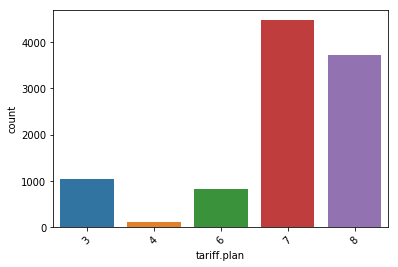

In [18]:
g=sns.countplot(x='tariff.plan',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

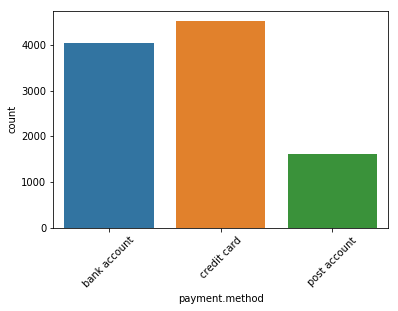

In [20]:
g=sns.countplot(x='payment.method',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

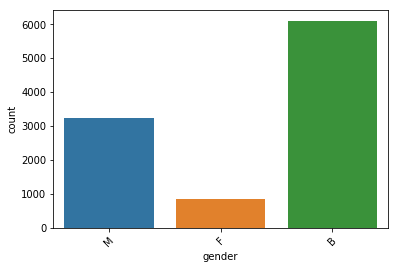

In [21]:
g=sns.countplot(x='gender',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

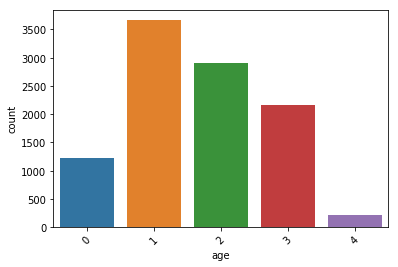

In [32]:
g=sns.countplot(x='age',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

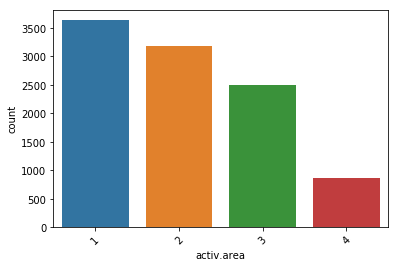

In [19]:
g=sns.countplot(x='activ.area',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

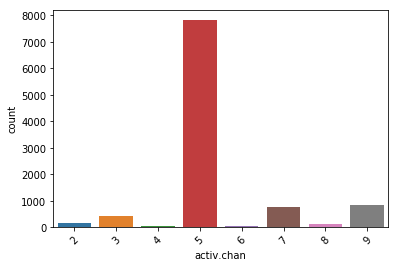

In [20]:
g=sns.countplot(x='activ.chan',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

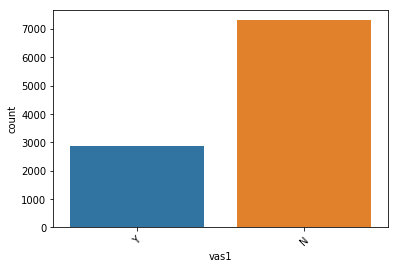

In [22]:
g=sns.countplot(x='vas1',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

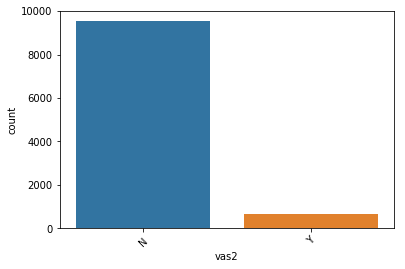

In [23]:
g=sns.countplot(x='vas2',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

## Visualize numerical features

In [ ]:
# Visualizing from train_df

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


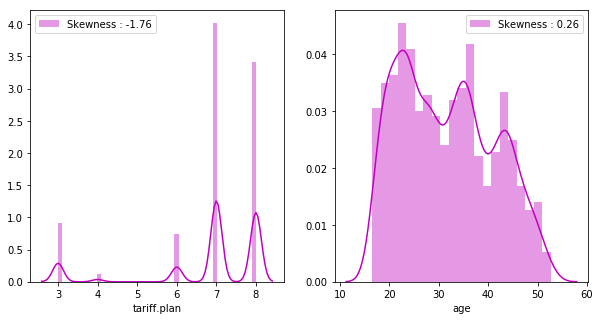

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["tariff.plan"], color="m", label="Skewness : %.2f"%(train_df["tariff.plan"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["age"], color="m", label="Skewness : %.2f"%(train_df["age"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()


# NICE IDEA--> COULD NOT MAKE IT WORK

# for i in range(len(numerical_list)):
#     g = sns.distplot(compatible_train_df[numerical_list[i]], color="m", label="Skewness : %.2f"%(compatible_train_df[numerical_list[i]].skew()), ax=ax[i])
#     g = g.legend(loc="best")

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


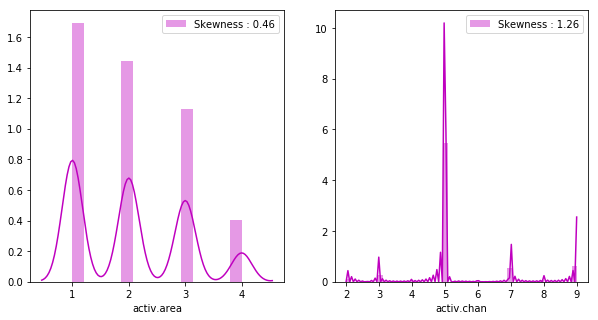

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["activ.area"], color="m", label="Skewness : %.2f"%(train_df["activ.area"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["activ.chan"], color="m", label="Skewness : %.2f"%(train_df["activ.chan"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


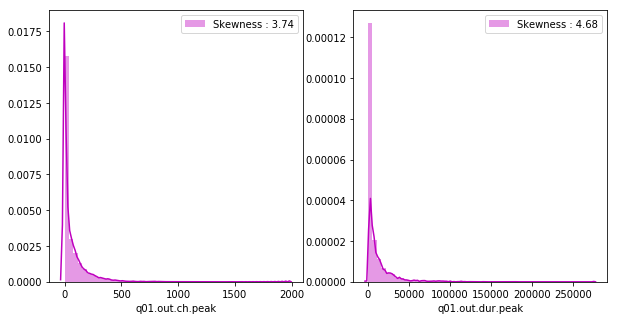

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q01.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q01.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q01.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q01.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


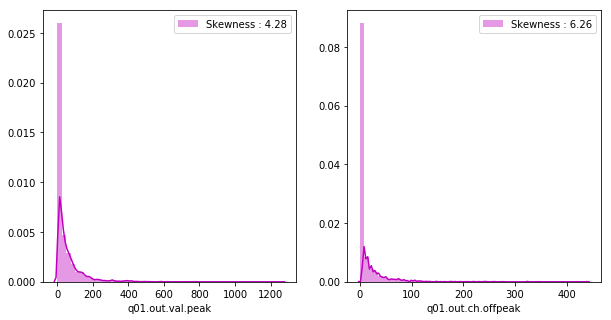

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q01.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q01.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q01.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q01.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


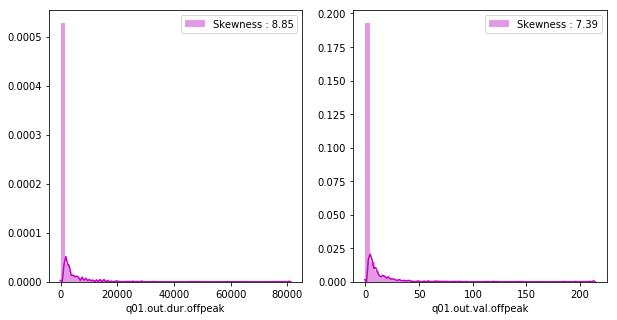

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q01.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q01.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q01.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q01.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


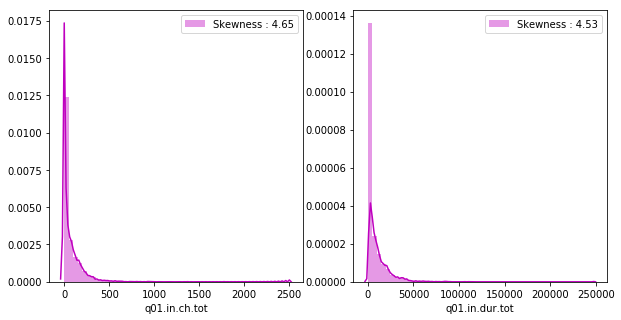

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q01.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q01.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q01.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q01.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


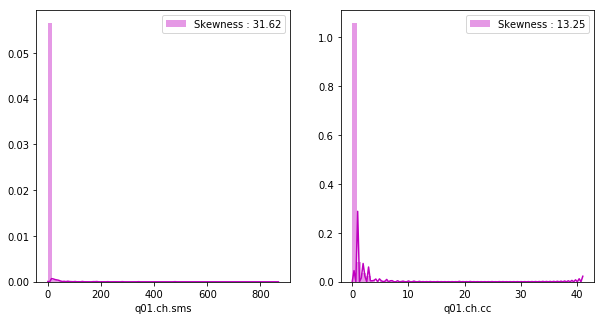

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q01.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q01.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q01.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q01.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


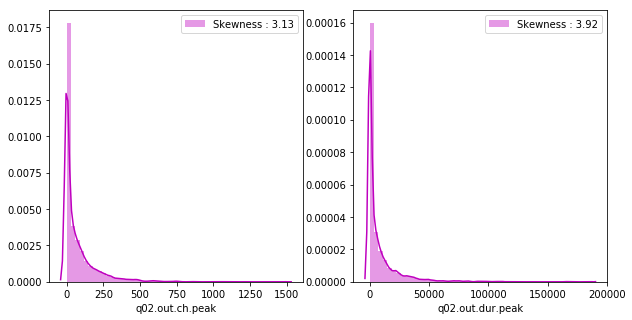

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q02.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q02.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q02.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q02.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


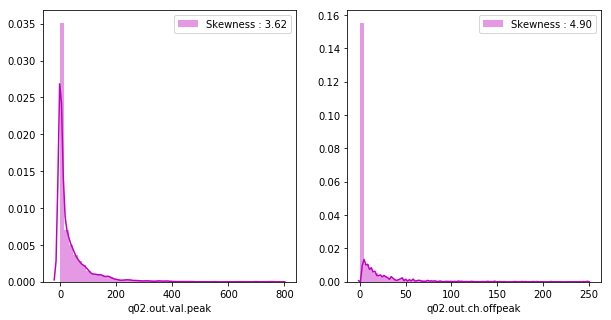

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q02.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q02.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q02.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q02.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


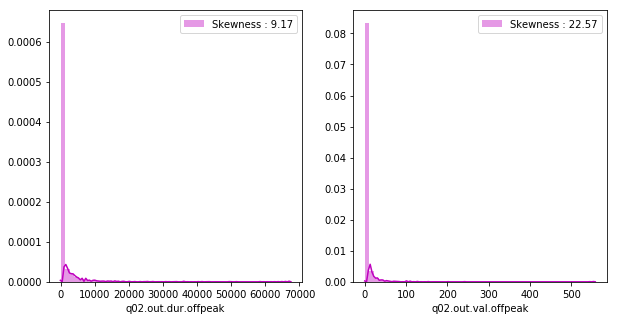

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q02.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q02.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q02.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q02.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


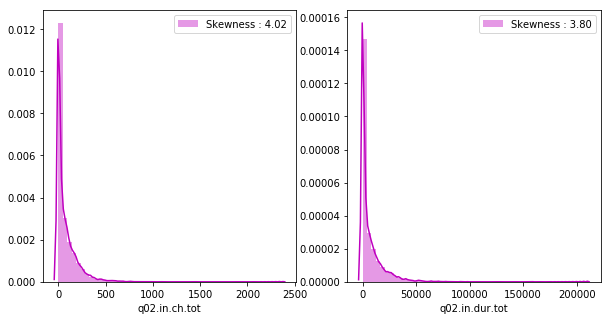

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q02.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q02.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q02.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q02.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


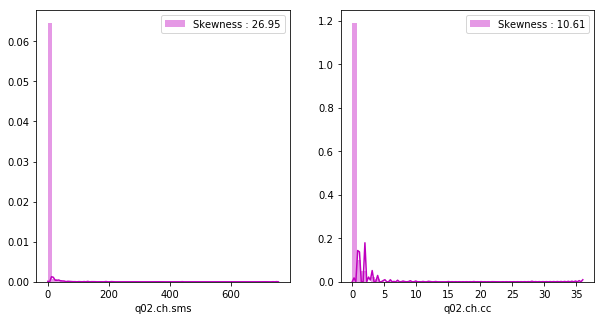

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q02.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q02.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q02.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q02.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


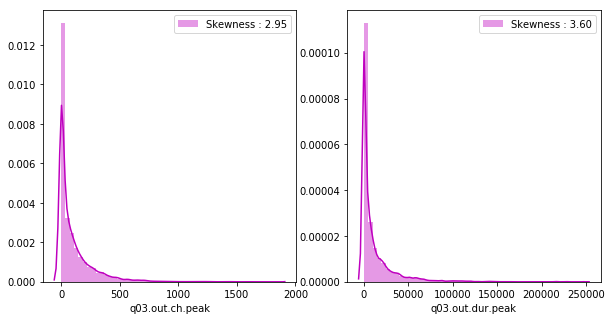

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q03.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q03.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q03.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q03.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


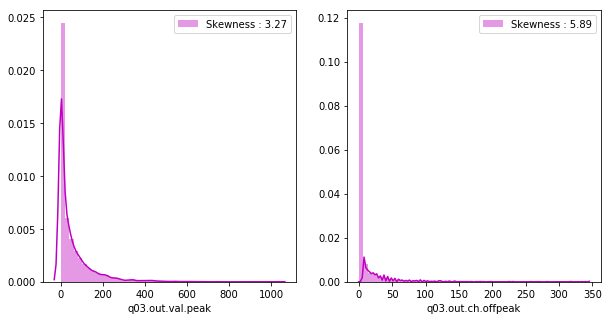

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q03.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q03.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q03.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q03.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


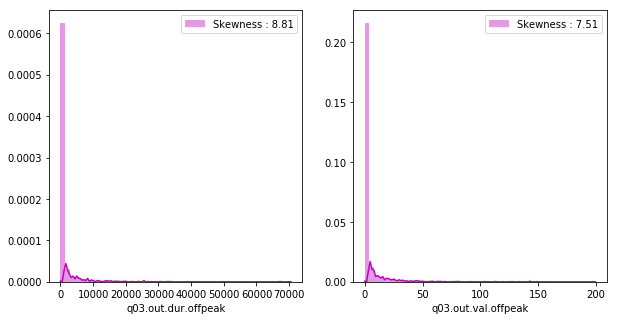

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q03.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q03.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q03.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q03.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


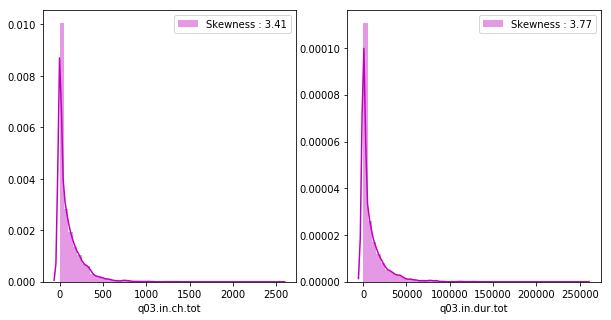

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q03.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q03.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q03.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q03.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


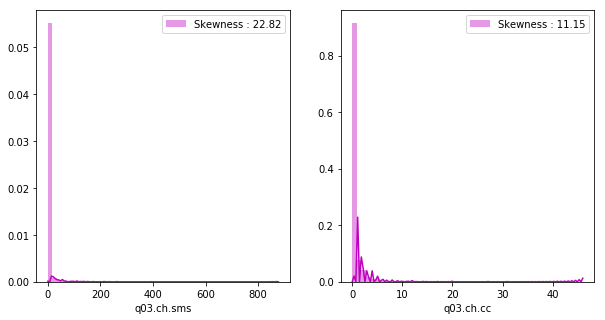

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q03.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q03.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q03.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q03.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


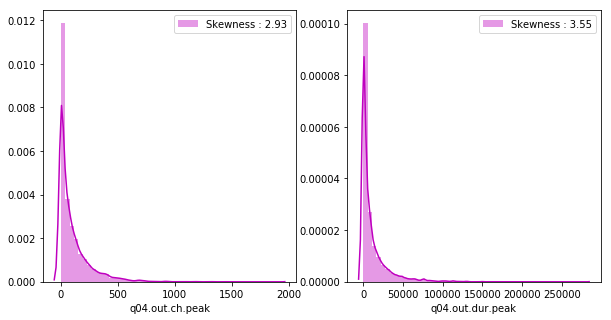

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q04.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q04.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q04.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q04.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


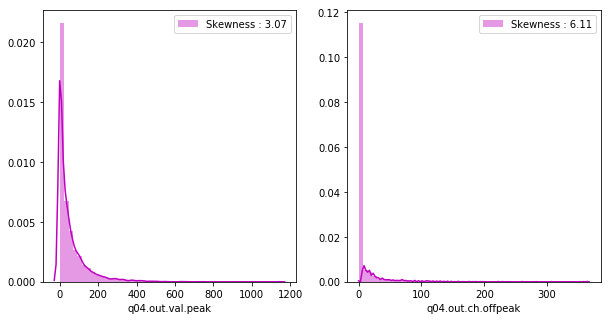

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q04.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q04.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q04.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q04.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


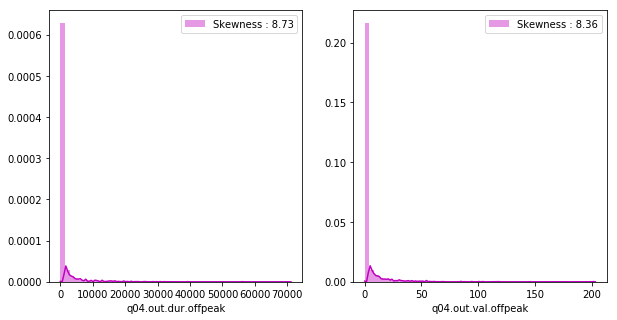

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q04.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q04.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q04.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q04.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


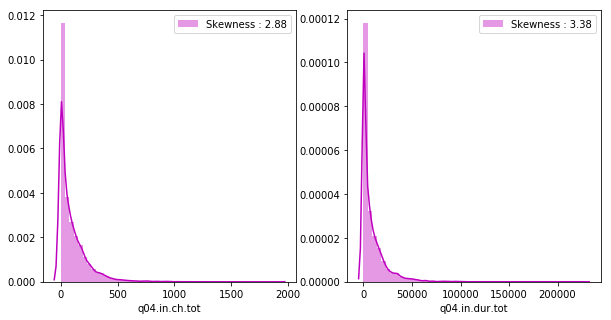

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q04.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q04.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q04.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q04.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


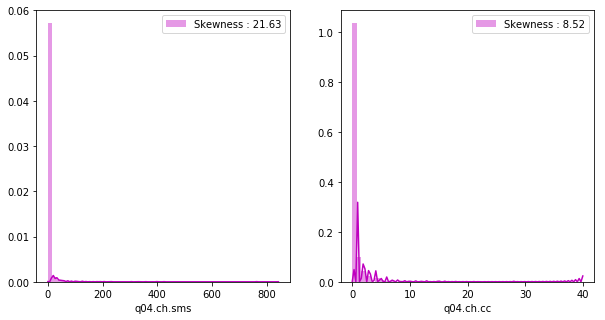

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q04.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q04.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q04.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q04.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


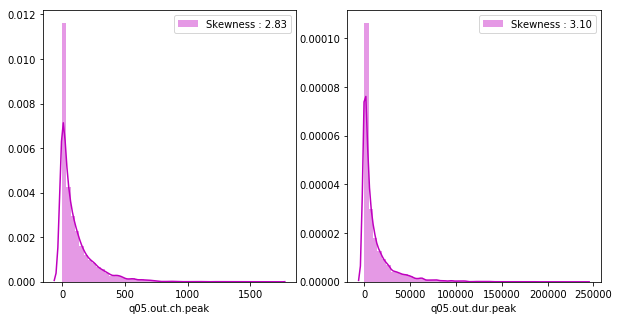

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q05.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q05.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q05.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q05.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


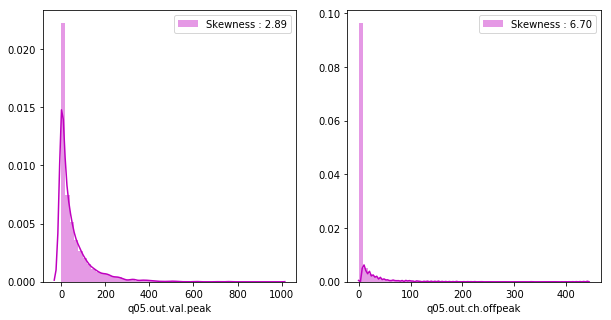

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q05.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q05.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q05.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q05.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


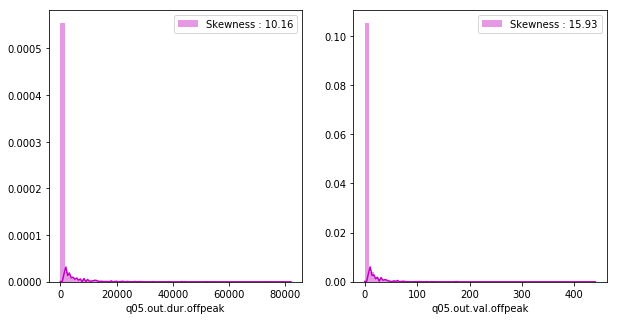

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q05.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q05.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q05.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q05.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


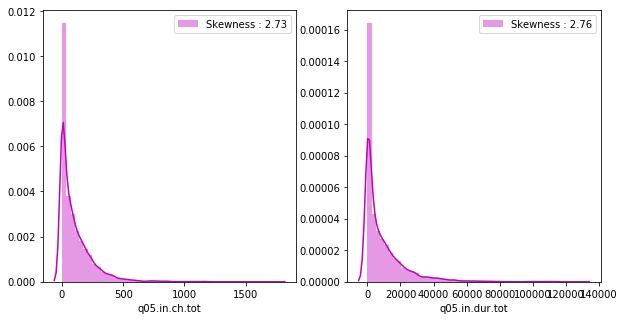

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q05.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q05.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q05.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q05.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


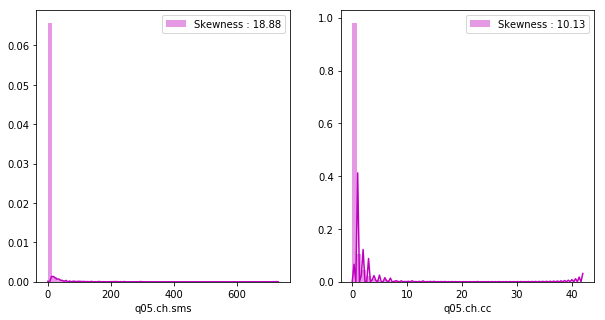

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q05.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q05.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q05.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q05.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


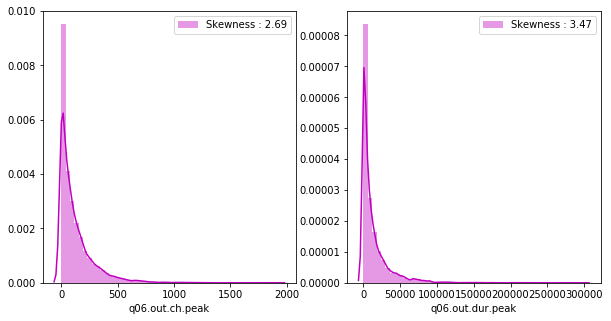

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q06.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q06.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q06.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q06.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


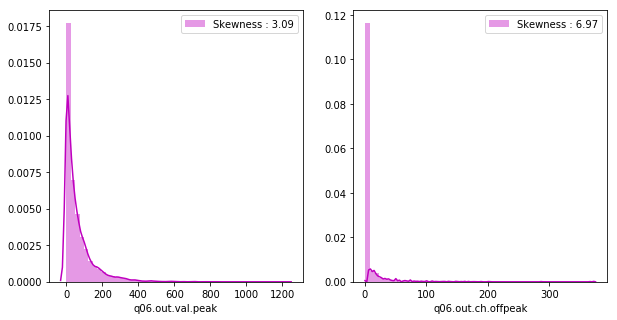

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q06.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q06.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q06.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q06.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


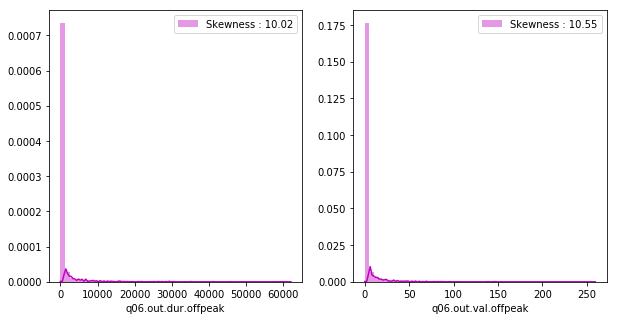

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q06.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q06.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q06.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q06.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


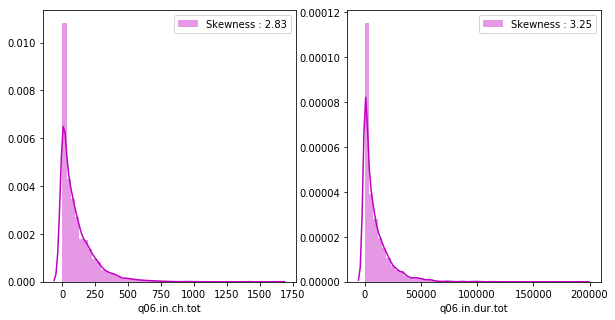

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q06.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q06.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q06.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q06.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


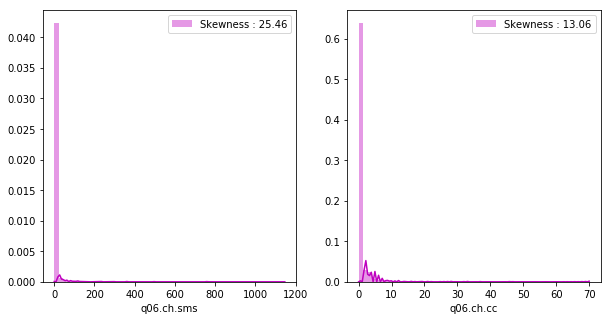

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q06.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q06.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q06.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q06.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


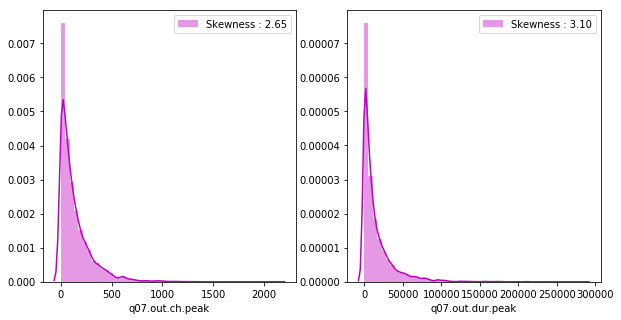

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q07.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q07.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q07.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q07.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


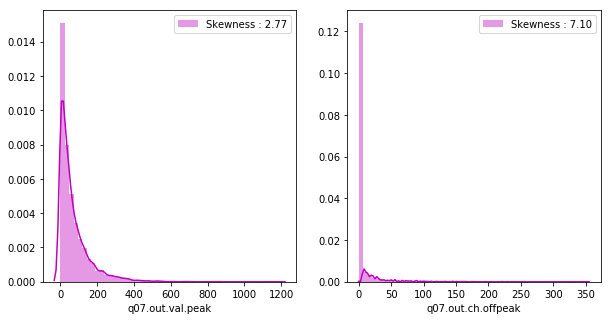

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q07.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q07.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q07.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q07.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


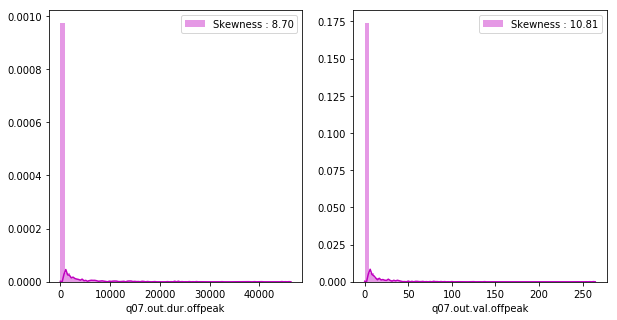

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q07.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q07.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q07.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q07.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


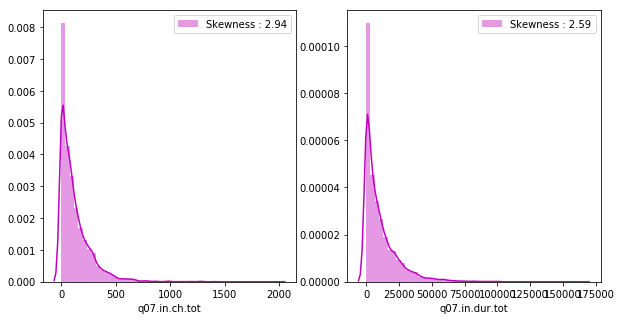

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q07.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q07.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q07.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q07.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


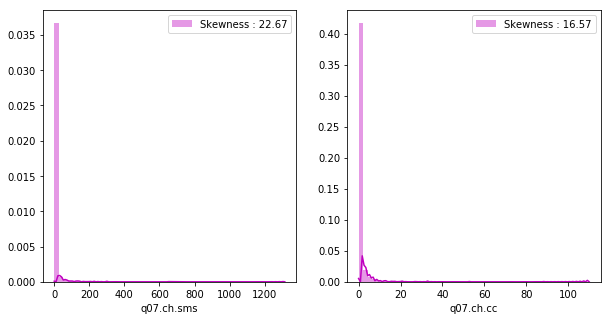

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q07.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q07.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q07.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q07.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


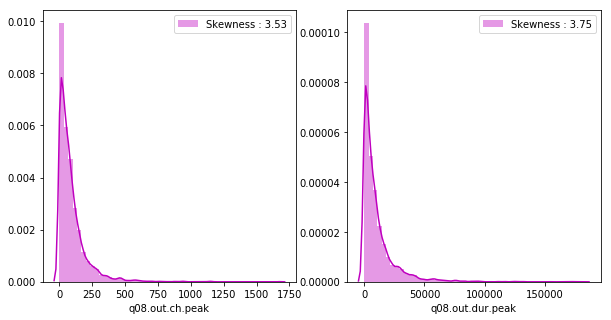

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q08.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q08.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q08.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q08.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


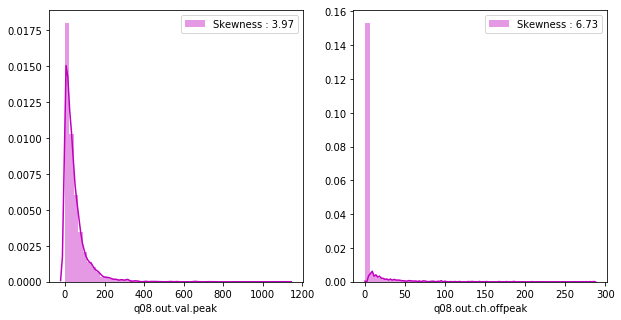

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q08.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q08.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q08.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q08.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


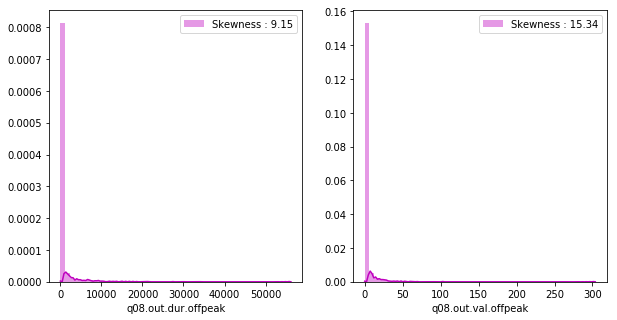

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q08.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q08.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q08.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q08.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


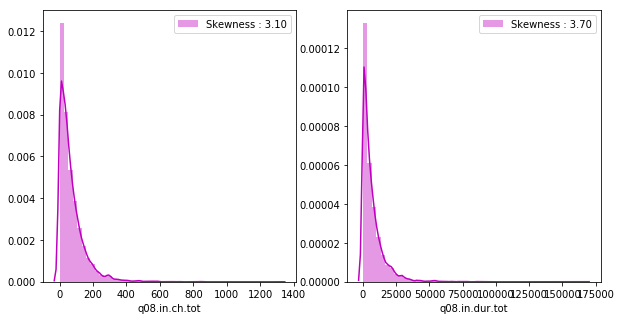

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q08.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q08.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q08.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q08.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


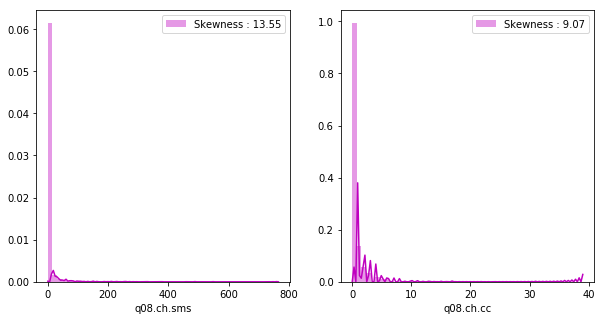

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q08.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q08.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q08.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q08.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


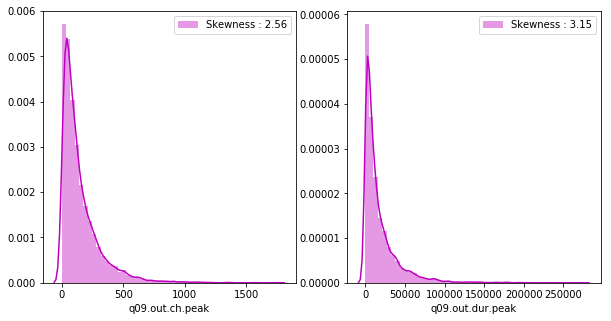

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q09.out.ch.peak"], color="m", label="Skewness : %.2f"%(train_df["q09.out.ch.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q09.out.dur.peak"], color="m", label="Skewness : %.2f"%(train_df["q09.out.dur.peak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


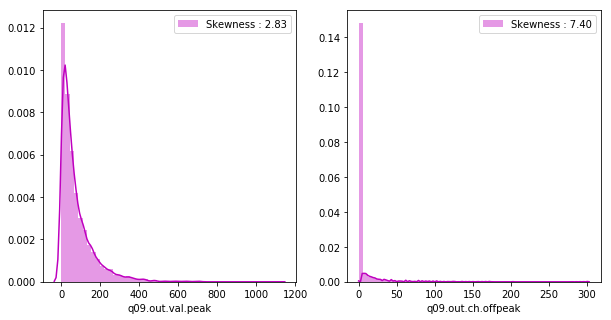

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q09.out.val.peak"], color="m", label="Skewness : %.2f"%(train_df["q09.out.val.peak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q09.out.ch.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q09.out.ch.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


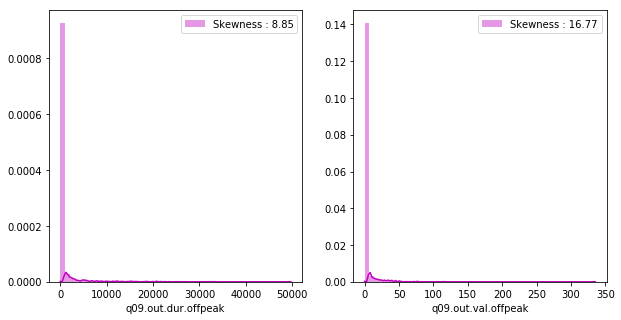

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q09.out.dur.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q09.out.dur.offpeak"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q09.out.val.offpeak"], color="m", label="Skewness : %.2f"%(train_df["q09.out.val.offpeak"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


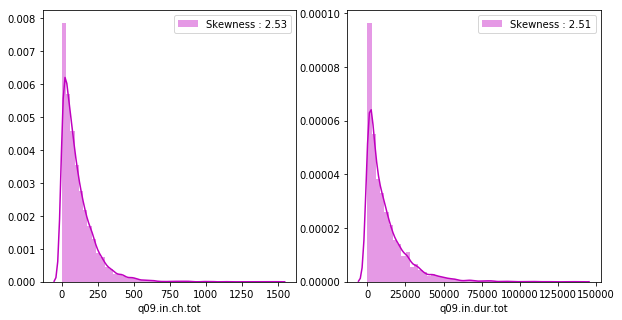

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q09.in.ch.tot"], color="m", label="Skewness : %.2f"%(train_df["q09.in.ch.tot"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q09.in.dur.tot"], color="m", label="Skewness : %.2f"%(train_df["q09.in.dur.tot"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

/home/lini/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


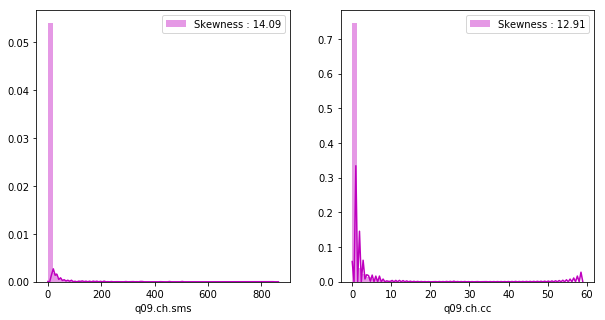

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.distplot(train_df["q09.ch.sms"], color="m", label="Skewness : %.2f"%(train_df["q09.ch.sms"].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(train_df["q09.ch.cc"], color="m", label="Skewness : %.2f"%(train_df["q09.ch.cc"].skew()), ax=ax[1])
g = g.legend(loc="best")

fig.show()

#### Small remarks

In [72]:
# Some variables are very skewed
# I will do prediction with them like this and then also perform logarithmic transformation and predict again

## Relationship between response and categorical variables

##### box plot

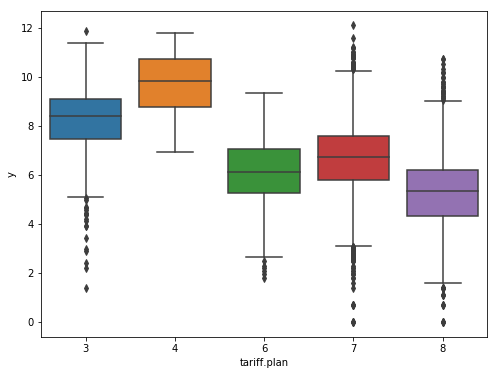

In [73]:
var = 'tariff.plan'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

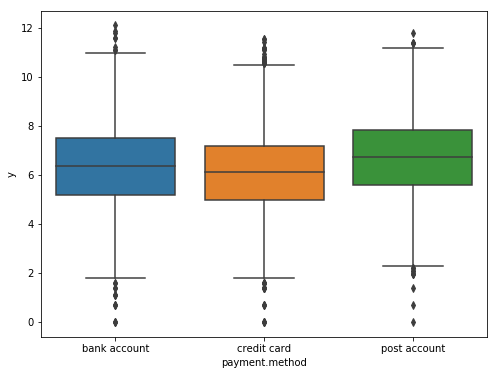

In [75]:
var = 'payment.method'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

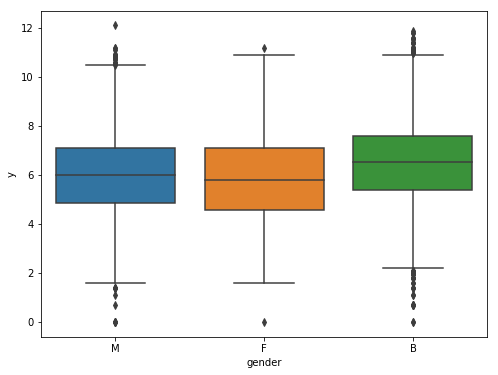

In [76]:
var = 'gender'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

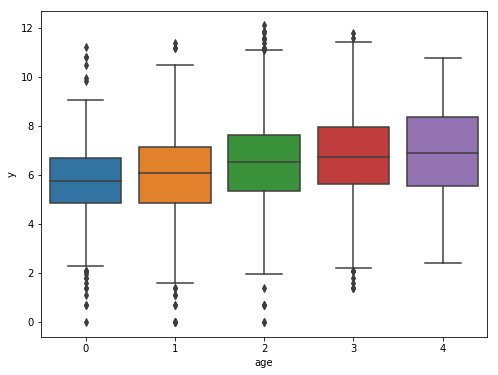

In [18]:
# from dataset
var = 'age'
data = pd.concat([dataset['y'], dataset[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

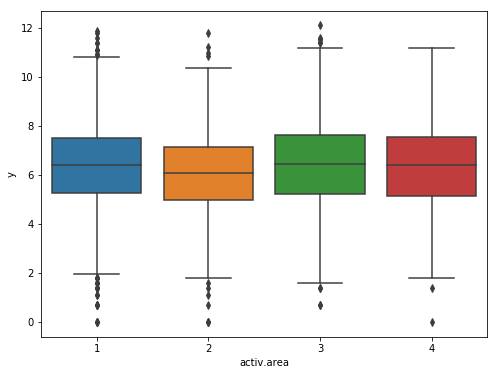

In [77]:
var = 'activ.area'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

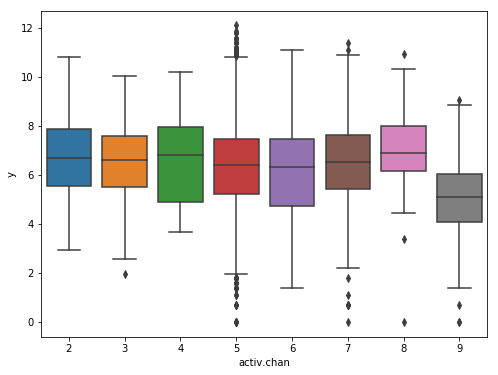

In [78]:
var = 'activ.chan'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

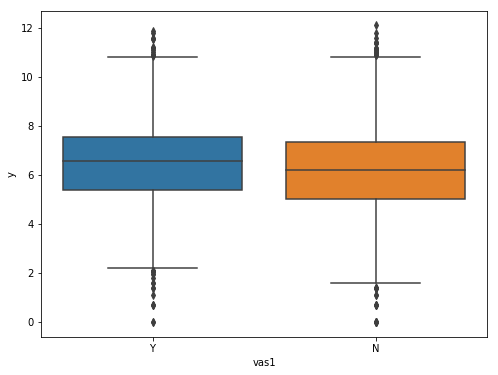

In [79]:
var = 'vas1'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

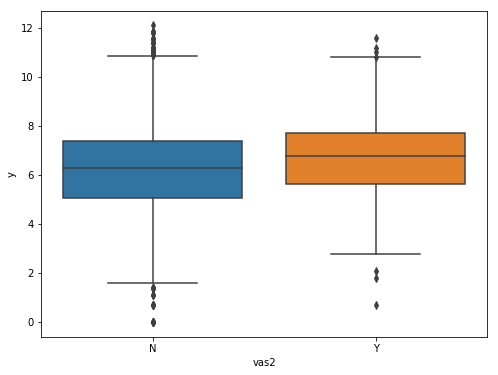

In [80]:
var = 'vas2'
data = pd.concat([train_df['y'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="y", data=data);

### Correlation matrix

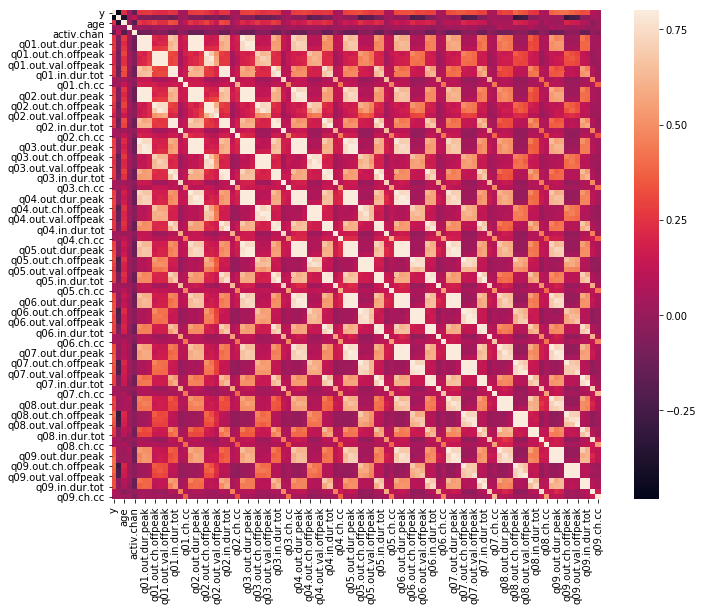

In [84]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [81]:
# I should maybe put it after cleaning

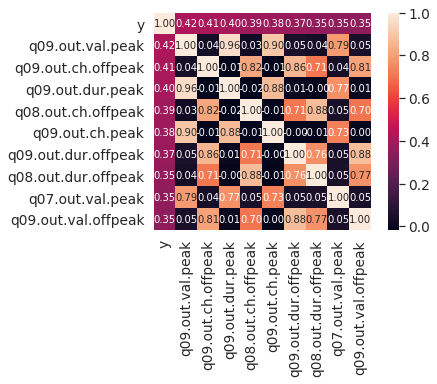

In [85]:
# ZOOMED correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'y')['y'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
# I can conclude from this correlation matrix that recent moths are more important for predicting y variable in
# in comparison with months that are very far away

# Pre-processing

In [20]:
# Check the minimum value of all numerical features
min_values = dataset[numerical_list].apply(lambda x: min(x)).sort_values(ascending=True)
m = pd.DataFrame({'Min' :min_values})
print(m.head())

print("\n")

print(f"q0m.in.dur.tot: duration of total incoming calls in month m")
print(f"q09.out.dur.peak: q0m.out.dur.peak: duration of total outgoing calls at peak tariff times in month m")

print("\n")

print(f"These values naturally cannot be lower than zero, and because of this I will delete observations which are wrong; to protect the integrity of the dataset")

                        Min
q03.in.dur.tot     -56826.0
q09.out.dur.peak     -688.0
q01.out.ch.peak         0.0
q07.out.ch.offpeak      0.0
q07.out.val.peak        0.0


q0m.in.dur.tot: duration of total incoming calls in month m
q09.out.dur.peak: q0m.out.dur.peak: duration of total outgoing calls at peak tariff times in month m


These values naturally cannot be lower than zero, and because of this I will delete observations which are wrong; to protect the integrity of the dataset


In [21]:
list_for_correction = ['q03.in.dur.tot', 'q09.out.dur.peak']
a1 = dataset[list_for_correction]
print(a1[a1 < 0].count())
print()
print('Three observations in total are lower than zero, and I will set them to zero.')

q03.in.dur.tot      2
q09.out.dur.peak    1
dtype: int64

Three observations in total are lower than zero, and I will set them to zero.


In [22]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


In [23]:
a1, a2 = dataset[dataset['q03.in.dur.tot'] < 0].index
a3 = dataset[dataset['q09.out.dur.peak'] < 0].index

In [24]:
dataset['q03.in.dur.tot'][a1] = np.int64(0)
dataset['q03.in.dur.tot'][a2] = np.int64(0)
dataset['q09.out.dur.peak'][a3] = np.int64(0)

/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# just a check
print(dataset['q03.in.dur.tot'][a1])
print(dataset['q03.in.dur.tot'][a2])
print(dataset['q09.out.dur.peak'][a3])

0
0
5531    0
Name: q09.out.dur.peak, dtype: int64


In [26]:
# Check the minimum value of all numerical features
min_values = dataset[numerical_list].apply(lambda x: min(x)).sort_values(ascending=True)
m = pd.DataFrame({'Min' :min_values})
print(m.head())

print("\n")

print(f"q0m.in.dur.tot: duration of total incoming calls in month m")
print(f"q09.out.dur.peak: q0m.out.dur.peak: duration of total outgoing calls at peak tariff times in month m")

print("\n")

print(f"No values smaller than zero! Great!")

                     Min
q01.out.ch.peak      0.0
q07.out.dur.offpeak  0.0
q07.out.ch.offpeak   0.0
q07.out.val.peak     0.0
q07.out.dur.peak     0.0


q0m.in.dur.tot: duration of total incoming calls in month m
q09.out.dur.peak: q0m.out.dur.peak: duration of total outgoing calls at peak tariff times in month m


No values smaller than zero! Great!


In [27]:
# dataset[list_for_correction][dataset[list_for_correction] < 0].count()

In [28]:
# This is for dropping observations that contain certain variables lower than zero
# Not good because I append y at the end, and then y does not match the inputs

# print('Shape before:')
# print(dataset.shape)
# print()
# dataset = dataset.drop(dataset[dataset['q03.in.dur.tot'] < 0].index)
# dataset = dataset.drop(dataset[dataset['q09.out.dur.peak'] < 0].index)
# print()
# print('Shape after:')
# print(dataset.shape)

In [29]:
dataset.shape

(10179, 98)

In [30]:
# list of vars to drop/not adjust
# deleted .dropna() in skew(x.dropna())

# Check the skew of all numerical features
skewed_feats = dataset[numerical_list].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
q02.ch.cc,39.044562
q05.ch.sms,35.138843
q01.ch.sms,34.364107
q02.ch.sms,33.838620
q03.ch.sms,30.266709
q04.ch.sms,28.733095
q06.ch.sms,27.108244
q07.ch.sms,23.224990
q02.out.val.offpeak,21.732476
q03.out.val.offpeak,20.825049


In [31]:
skewness.shape

(90, 1)

In [32]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


In [33]:
a1 = skewness['Skew']
a2 = skewness.index
a3 = [x for x in a2]
a3

['q02.ch.cc',
 'q05.ch.sms',
 'q01.ch.sms',
 'q02.ch.sms',
 'q03.ch.sms',
 'q04.ch.sms',
 'q06.ch.sms',
 'q07.ch.sms',
 'q02.out.val.offpeak',
 'q03.out.val.offpeak',
 'q08.ch.sms',
 'q09.ch.sms',
 'q01.ch.cc',
 'q07.ch.cc',
 'q09.ch.cc',
 'q04.ch.cc',
 'q06.ch.cc',
 'q09.out.val.offpeak',
 'q05.out.val.offpeak',
 'q08.out.val.offpeak',
 'q04.out.dur.offpeak',
 'q06.out.dur.offpeak',
 'q03.out.dur.offpeak',
 'q03.ch.cc',
 'q05.ch.cc',
 'q05.out.dur.offpeak',
 'q06.out.val.offpeak',
 'q09.out.dur.offpeak',
 'q07.out.val.offpeak',
 'q07.out.dur.offpeak',
 'q01.out.dur.offpeak',
 'q04.out.val.offpeak',
 'q02.out.dur.offpeak',
 'q08.out.dur.offpeak',
 'q08.out.ch.offpeak',
 'q08.ch.cc',
 'q07.out.ch.offpeak',
 'q06.out.ch.offpeak',
 'q09.out.ch.offpeak',
 'q05.out.ch.offpeak',
 'q01.out.val.offpeak',
 'q04.out.ch.offpeak',
 'q03.out.ch.offpeak',
 'q01.out.ch.offpeak',
 'q01.out.dur.peak',
 'q02.out.ch.offpeak',
 'q01.out.val.peak',
 'q01.in.ch.tot',
 'q02.out.dur.peak',
 'q01.in.dur.tot',


## Normalizing skewed numerical variables

In [34]:
# interesting approach

# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

#
# I can also maybe use this one and compare results
# X[skewness_features] = np.log1p(X[skewness_features])

from scipy.special import boxcox1p
skewed_features = [x for x in skewness.index]
lam = 0.15
for feat in skewed_features:
    #dataset[feat] += 1
    dataset[feat] = boxcox1p(dataset[feat], lam)
    
#dataset[skewed_features] = np.log1p(dataset[skewed_features])

In [35]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


#### Manual transformation - not used

In [ ]:
# manual transformations instead of Box-Cox

In [ ]:
# histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [ ]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [ ]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [ ]:
# if the variable has lot zero observations because of some factor

In [ ]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(
    len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [ ]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

In [ ]:
# histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF'] > 0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(
    df_train[df_train['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=plt)

In [ ]:
# TASK --->>> Find a way to check which variables are skewed and to have a list for transformation

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

In [ ]:
# for skewed variables --> correct
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

## Creating dummy variables

In [36]:
# ENCODING - get dummies; convert categorical variable into dummy
dataset=pd.get_dummies(dataset, drop_first=True)

In [37]:
print(np.any(dataset.isna()))
print(np.any(dataset.isna()))
print(np.all(dataset.isnull()))
print(np.all(dataset.isnull()))

False
False
False
False


## PCA

In [ ]:
# Maybe I should PCA

In [ ]:
# X_scaled = scaler.fit(X).transform(X)
# y_log = np.log(train.SalePrice)
# test_X_scaled = scaler.transform(test_X)
# pca = PCA(n_components=410)
# X_scaled=pca.fit_transform(X_scaled)
# test_X_scaled = pca.transform(test_X_scaled)

# One by one: Model-fitting, hyperparameter optimization and predicting

## Splitting into train/test

In [ ]:
# you know the logarithm of the total duration of outgoing calls, in seconds, for month 10 [denoted as y]
# transform it back to the original, or maybe not because it is skewed

In [38]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]

# test.drop(labels=["y"],axis = 1,inplace=True)

In [39]:
print(np.any(train.isna()))
print(np.any(train.isnull()))
print(np.all(train.isna()))
print(np.all(train.isnull()))

print(f"At least we know now that train has some NaN values!")

False
False
False
False
At least we know now that train has some NaN values!


In [40]:
print(np.any(test.isna()))
print(np.any(test.isnull()))
print(np.all(test.isna()))
print(np.all(test.isnull()))

print(f"At least we know now that test has some NaN values!")

False
False
False
False
At least we know now that test has some NaN values!


In [41]:
## Separate train features and label
y_train = df_for_appending
X_train = train

In [42]:
X_train.head()

,q01.out.ch.peak,q01.out.dur.peak,q01.out.val.peak,q01.out.ch.offpeak,q01.out.dur.offpeak,q01.out.val.offpeak,q01.in.ch.tot,q01.in.dur.tot,q01.ch.sms,q01.ch.cc,...,activ.area_4,activ.chan_3,activ.chan_4,activ.chan_5,activ.chan_6,activ.chan_7,activ.chan_8,activ.chan_9,vas1_Y,vas2_Y
0,7.511251,23.299943,7.786312,8.52065,26.74464,7.434618,3.618223,14.474255,3.237728,2.259674,...,0,0,0,1,0,0,0,0,1,0
1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0
2,7.104297,20.790023,6.382353,0.00000,0.00000,0.000000,5.591427,14.854510,0.000000,0.000000,...,0,0,0,0,0,1,0,0,1,0
3,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0
4,8.864879,25.982582,7.707446,0.00000,0.00000,0.000000,7.848990,25.641034,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0


In [43]:
# we have X_train, y_train and test

In [44]:
print(np.any(X_train.isna()))
print(np.any(y_train.isna()))
print(np.any(test.isna()))
print(np.all(X_train.isnull()))
print(np.all(y_train.isnull()))
print(np.all(test.isnull()))

False
False
False
False
False
False


In [45]:
#Validation function
n_folds = 5

# RMSLE - Root Mean Squared Log Error .
# This metric is used when the Target variable is converted into Log(Target)
# Check what am I actually using

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf, n_jobs=-1))
    return(rmse)

## Base models

### Linear Regression

In [46]:
# Choose the model
lr = LinearRegression()

score = rmse_cv(lr)
print("\nLinearReg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

scoring_dict = {'lin_reg': score.mean()}
scoring_dict


LinearReg score: 1.1547 (0.0336)



{'lin_reg': 1.1547450195445186}

### Ridge

Text(0, 0.5, 'rmse')

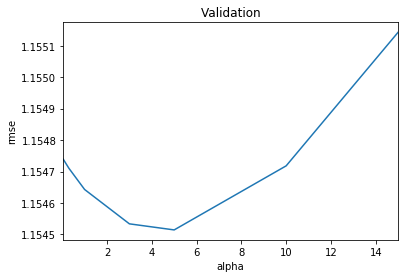

In [47]:
# Searching for optimal alpha

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [48]:
cv_ridge.mean()

1.1547167027812486

In [49]:
scoring_dict['ridge_1'] = cv_ridge.mean()
scoring_dict

{'lin_reg': 1.1547450195445186, 'ridge_1': 1.1547167027812486}

### Lasso

Text(0, 0.5, 'rmse')

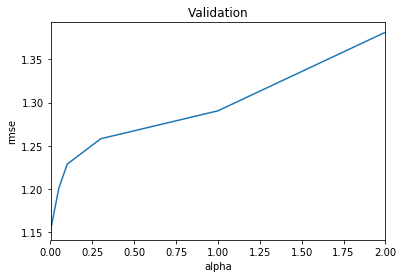

In [50]:
# Searching for optimal alpha

alphas = [0.0005, 0.001, 0.05, 0.1, 0.3, 1, 2]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [51]:
print(cv_lasso.mean())

scoring_dict['lasso1'] = cv_lasso.mean()
scoring_dict

1.2378650986033979

In [57]:
# Automatic cross-validation

In [53]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
rmse_cv(model_lasso).mean()

/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. 

1.1523338712756073

In [54]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [55]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 98 variables and eliminated the other 16 variables


In [56]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

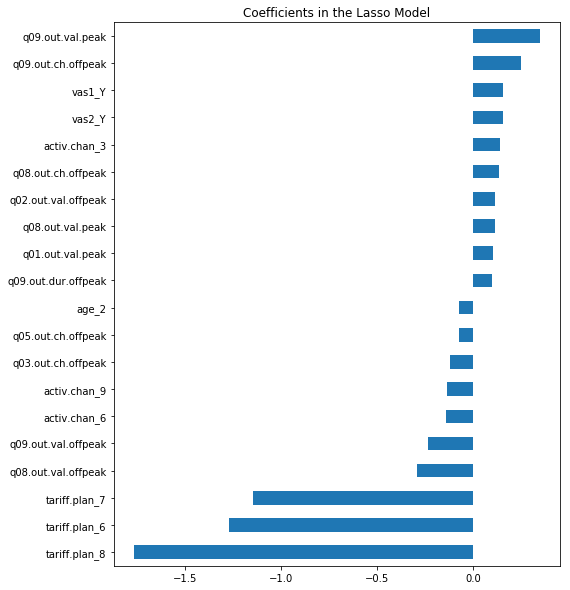

In [57]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [58]:
# Let's see how these base models perform on the data by evaluating the cross-validation rmse error

In [59]:
# LASSO Regression
# This model may be very sensitive to outliers. So we need to made it more robust on them.
# For that we use the sklearn's Robustscaler() method on pipeline


lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [61]:
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

scoring_dict['lasso2'] = score.mean()
scoring_dict


Lasso score: 1.1519 (0.0327)



{'lin_reg': 1.1547450195445186,
 'ridge_1': 1.1547167027812486,
 'lasso1': 1.2378650986033979,
 'lasso2': 1.151921599658507}

### ENet

In [62]:
# Elastic Net Regression
# again made robust to outliers

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [63]:
score = rmse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

scoring_dict['ENet'] = score.mean()
scoring_dict

ElasticNet score: 1.1521 (0.0328)



### KRR

In [65]:
# Kernel Ridge Regression

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [66]:
score = rmse_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

scoring_dict['KRR'] = score.mean()
scoring_dict

Kernel Ridge score: 1.3106 (0.0329)



### SVR (kernel='linear')

### SVR (kernel='rbf')

### GBR

In [68]:
# Gradient Boosting Regression
# With huber loss that makes it robust to outliers

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [69]:
score = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

scoring_dict['GBoost'] = score.mean()
scoring_dict

Gradient Boosting score: 1.1548 (0.0228)



{'lin_reg': 1.1547450195445186,
 'ridge_1': 1.1547167027812486,
 'lasso1': 1.2378650986033979,
 'lasso2': 1.151921599658507,
 'ENet': 1.1520618384035426,
 'KRR': 1.3105844545632088,
 'GBoost': 1.1548272799845791}

### XGB

In [70]:
# XGBoost

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [71]:
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

scoring_dict['XGB_no_grid'] = score.mean()
scoring_dict

Xgboost score: 1.1644 (0.0279)



{'lin_reg': 1.1547450195445186,
 'ridge_1': 1.1547167027812486,
 'lasso1': 1.2378650986033979,
 'lasso2': 1.151921599658507,
 'ENet': 1.1520618384035426,
 'KRR': 1.3105844545632088,
 'GBoost': 1.1548272799845791,
 'XGB': 1.1644232462560637,
 'XGB_no_grid': 1.1644232462560637}

In [86]:
# Choose the model
xgb1 = XGBRegressor()
seed = 1

# Various combinations of parameters to tune
parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(mean_squared_error)

# Set cross-validation
c_v = KFold(n_splits= 3, random_state= seed, shuffle=True)

# Run the grid search
grid_obj = GridSearchCV(xgb1,
                        parameters,
                        scoring=acc_scorer,
                        cv = c_v,
                        n_jobs = -1,
                        verbose=3)


grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_grid = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
xgb_grid.fit(X_train, y_train)


# Best score and best parameters
print('-------Best score----------')
print(grid_obj.best_score_)
print('-------Best params----------')
print(grid_obj.best_params_)

print(f"root_neg_mean_sq_err: {np.sqrt(grid_obj.cv_results_['mean_test_score']).mean()}")
scoring_dict['xgb_grid'] = np.sqrt(grid_obj.cv_results_['mean_test_score']).mean()

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.1min finished


-------Best score----------
1.3386297734626782
-------Best params----------
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


root_neg_mean_sq_err: 1.1438296096219274


### SGD Regression

### LightGBM

In [89]:
# LightGBM

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [90]:
score = rmse_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

scoring_dict['LightGBM'] = score.mean()
scoring_dict

LGBM score: 1.1287 (0.0276)



{'lin_reg': 1.1547450195445186,
 'ridge_1': 1.1547167027812486,
 'lasso1': 1.2378650986033979,
 'lasso2': 1.151921599658507,
 'ENet': 1.1520618384035426,
 'KRR': 1.3105844545632088,
 'GBoost': 1.1548272799845791,
 'XGB': 1.1644232462560637,
 'XGB_no_grid': 1.1644232462560637,
 'xgb_grid': 1.1438296096219274,
 'LightGBM': 1.1287088537162295}

In [91]:
table = pd.DataFrame(scoring_dict.items(), columns=['model','mean_rmse'])
table

,model,mean_rmse
0,lin_reg,1.154745
1,ridge_1,1.154717
2,lasso1,1.237865
3,lasso2,1.151922
4,ENet,1.152062
5,KRR,1.310584
6,GBoost,1.154827
7,XGB,1.164423
8,XGB_no_grid,1.164423
9,xgb_grid,1.143830


In [ ]:
# solution writing

In [92]:
# Fitting the model and making predictions
model_lgb.fit(X_train, y_train)
lgb_pred = model_lgb.predict(test)
# lgb_pred

array([5.55275073, 8.70958723, 4.0656304 , ..., 9.10300552, 5.03352647,
       4.48146326])

In [95]:
sub = pd.DataFrame()
sub['y'] = lgb_pred
sub.to_csv('submission.txt',index=False, header=False)

In [ ]:
# if I need to exponentiate

In [98]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(test)) #need to remove np.expm1 which expontiate the output
print(rmsle(y_train, xgb_train_pred))

0.6604064318454058


In [96]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train) # here something is weird, I should put test?
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.9874637558808355


In [99]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, xgb_train_pred*0.5 + lgb_train_pred*0.5 ))

RMSLE score on train data:
0.8100426167973973


In [ ]:
# preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
# solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
# solution.to_csv("ridge_sol.csv", index = False)

In [ ]:
# Submission

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub.to_csv('submission.csv',index=False)

# Trying out keras

In [ ]:
# 1st version

In [79]:
X_train = StandardScaler().fit_transform(X_train)

/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [80]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 3)

In [81]:
X_tr.shape

(4500, 114)

In [95]:
model = Sequential()
model.add(Dense(114, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))


sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss=losses.mean_squared_error, optimizer=sgd)

# model.compile(loss=losses.mean_squared_logarithmic_error, optimizer=sgd)

# model.compile(loss = "mse", optimizer = "adam")
# model.compile(optimizer='rmsprop', loss='mse')

/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=114, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               29440     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 29,697
Trainable params: 29,697
Non-trainable params: 0
_________________________________________________________________


In [97]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 4500 samples, validate on 1500 samples
Epoch 1/1
4500/4500 [==============================] - 0s 69us/step - loss: 2.5889 - val_loss: 1.9435


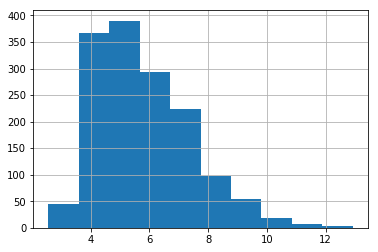

In [98]:
pd.Series(model.predict(X_val)[:,0]).hist()

In [ ]:
# 2nd version

In [99]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(114, input_dim=114, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [103]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [105]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -2.00 (0.11) MSE


In [ ]:
# 3rd version

In [96]:
def build_model():
  model = Sequential([
    Dense(114, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
    Dense(114, activation=tf.nn.relu),
    Dense(1)
  ])

  optimizer = optimizers.rmsprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [97]:
model = build_model()

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 114)               13110     
_________________________________________________________________
dense_2 (Dense)              (None, 114)               13110     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 115       
Total params: 26,335
Trainable params: 26,335
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [100]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,1.842868,1.026523,1.842868,0.062950,0.188488,0.062950,995
996,1.884999,1.035844,1.884999,0.065115,0.193071,0.065115,996
997,1.924375,1.038699,1.924375,0.058424,0.181997,0.058424,997
998,1.848149,1.030763,1.848149,0.060814,0.186830,0.060814,998
999,1.882272,1.028239,1.882272,0.061161,0.185499,0.061161,999


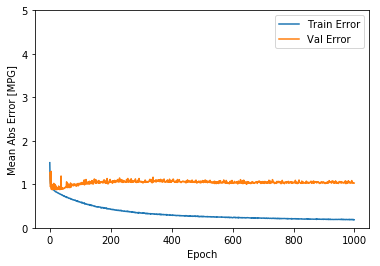

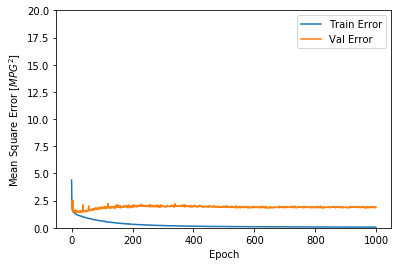

In [101]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.......................

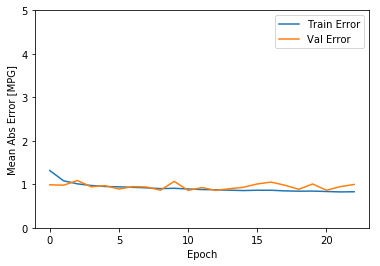

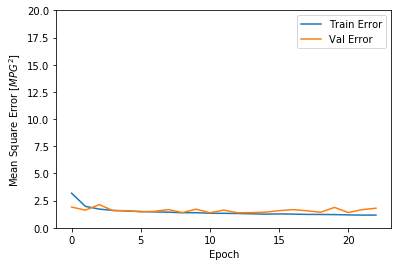

In [102]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [103]:
loss, mae, mse = model.evaluate(X_train, y_train, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  0.92 MPG


In [108]:
test_predictions = model.predict(test).flatten()
test_predictions

array([5.913082 , 9.709701 , 4.280265 , ..., 8.602092 , 5.5738473,
       4.8339057], dtype=float32)

In [110]:
sub = pd.DataFrame()
sub['y'] = test_predictions
sub.head()
sub.to_csv('submission-keras.txt',index=False, header=False)

# Look into it (pipelines + notes)

In [ ]:
# ------------- Modelling -------------
# 30-fold cross-validation
# Stacking: on each run of cross-validation I fit 5 models (l2, l1, GBR, ENet and LGB)
# Then we make 5 predictions using these models on left-out fold and add geometric mean of these predictions
# Finally, use lasso on these six predictors to forecast values on the left-out fold
# Save all the models (in total we have 30*6=180 models)
nF = 20

kf = KFold(n_splits=nF, random_state=241, shuffle=True)

test_errors_l2 = []
train_errors_l2 = []
test_errors_l1 = []
train_errors_l1 = []
test_errors_GBR = []
train_errors_GBR = []
test_errors_ENet = []
test_errors_LGB = []
test_errors_stack = []
test_errors_ens = []
train_errors_ens = []

models = []

pred_all = []

ifold = 1

for train_index, test_index in kf.split(X):
    print('fold: ',ifold)
    ifold = ifold + 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # ridge
    l2Regr = Ridge(alpha=9.0, fit_intercept = True)
    l2Regr.fit(X_train, y_train)
    pred_train_l2 = l2Regr.predict(X_train)
    pred_test_l2 = l2Regr.predict(X_test)
    
    # lasso
    l1Regr = make_pipeline(RobustScaler(), Lasso(alpha = 0.0003, random_state=1, max_iter=50000))
    l1Regr.fit(X_train, y_train)
    pred_train_l1 = l1Regr.predict(X_train)
    pred_test_l1 = l1Regr.predict(X_test)
    
    # GBR      
    myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
    
    myGBR.fit(X_train,y_train)
    pred_train_GBR = myGBR.predict(X_train)

    pred_test_GBR = myGBR.predict(X_test)
    
    # ENet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=4.0, l1_ratio=0.005, random_state=3))
    ENet.fit(X_train, y_train)
    pred_train_ENet = ENet.predict(X_train)
    pred_test_ENet = ENet.predict(X_test) 
    
    # LGB
    myLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=600,
                              max_bin = 50, bagging_fraction = 0.6,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
    myLGB.fit(X_train, y_train)
    pred_train_LGB = myLGB.predict(X_train)
    pred_test_LGB = myLGB.predict(X_test)      
    
    # Stacking
    stackedset = pd.DataFrame({'A' : []})
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l2)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l1)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_GBR)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_ENet)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_LGB)],axis=1)
    prod = (pred_test_l2*pred_test_l1*pred_test_GBR*pred_test_ENet*pred_test_LGB) ** (1.0/5.0)
    stackedset = pd.concat([stackedset,pd.DataFrame(prod)],axis=1)
    Xstack = np.array(stackedset)
    Xstack = np.delete(Xstack, 0, axis=1)
    l1_staked = Lasso(alpha = 0.0001,fit_intercept = True)
    l1_staked.fit(Xstack, y_test)
    pred_test_stack = l1_staked.predict(Xstack)
    
    models.append([l2Regr,l1Regr,myGBR,ENet,myLGB,l1_staked])
    
    test_errors_l2.append(np.square(pred_test_l2 - y_test).mean() ** 0.5)
    test_errors_l1.append(np.square(pred_test_l1 - y_test).mean() ** 0.5)
    test_errors_GBR.append(np.square(pred_test_GBR - y_test).mean() ** 0.5)
    test_errors_ENet.append(np.square(pred_test_ENet - y_test).mean() ** 0.5)
    test_errors_LGB.append(np.square(pred_test_LGB - y_test).mean() ** 0.5)
    test_errors_stack.append(np.square(pred_test_stack - y_test).mean() ** 0.5)

In [ ]:
# Adaptive regression spline

In [ ]:
#mars solution
model = Earth()

model = Earth(max_degree=2, penalty=1.0, minspan_alpha = 0.01, endspan_alpha = 0.01, endspan=5) #2nd degree formula is necessary to see interactions, penalty and alpha values for making model simple

model.fit(X_train, y_train)
model.score(X_train, y_train)
#y_pred = model.predict(train["SalePrice"])


y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) # inverse log transform the results

print(model)
print(model.summary())
print(y_pred)

#Final_labels_new = np.expm1(model.predict(y_pred))


In [ ]:
# Also use all these models:

# LinearRegression
# Ridge
# Lasso
# Random Forrest
# Gradient Boosting Tree
# Support Vector Regression
# Linear Support Vector Regression
# ElasticNet
# Stochastic Gradient Descent
# BayesianRidge
# KernelRidge
# ExtraTreesRegressor
# XgBoost

In [ ]:
# need to use grid for boosting

# def grid_get(self,X,y,param_grid):
#         grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
#         grid_search.fit(X,y)
#         print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
#         grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
#         print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [ ]:
# CHECK WHAT IS BETTER, IF Y IS EXPONENTIATED OR LEFT AS IT IS

In [ ]:
# # set up different models and evaluate performance
# # try in this order
# Ridge regression
# SVR (kernel='linear')
# SVR (kernel='rbf')
# EnsembleRegressors
# Lasso
# Elastic Net

In [ ]:
# estimate 

In [ ]:
# # reduce dimensions and then try models
# Randomized PCA
# Isomap
# Spectral Embedding
# LLE
# kernel approximation

In [ ]:
# # set up different models and evaluate performance
# # try in this order
# Ridge regression
# SVR (kernel='linear')
# SVR (kernel='rbf')
# EnsembleRegressors
# Lasso
# Elastic Net

In [91]:
# How to do leave one out cross validation?


In [ ]:
# Setting the model 
logreg = LogisticRegression()
# Fitting the model 
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(test)
logreg_pred = logreg_pred + 1 # to return it to initial binary values (1 and 2)
np.savetxt("sol_logit.txt", logreg_pred, newline="\n")

In [ ]:
# RFECV - check out

In [ ]:
# another option for writing
with open('competition.txt', 'w') as file_1:
    
    for number in result2:
        file_1.write("%d\n" % (number))

In [ ]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [ ]:
# need to check if I need to apply log transform
# need to check if I need to standardize
# need to exponentiate y, then do modelling, and then take a log of the prediction (try both ways, with original and log data)
# team: lanister
# smoothing splines will help us win, very important
# if you want to refine further, you can check for outliers and delete them manually
# 24.03. deadline

In [ ]:
# Use professor's notebook and use stuff that you did not use

In [ ]:
# Visualization of learning curve for different models

# Other

## Stacking models

### Simplest Stacking approach : Averaging base models

In [ ]:
# We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn
# with our model and also to laverage encapsulation and code reuse (inheritance)

In [90]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
# Averaged base models score
# We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add more
# models in the mix.

averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [89]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [127]:
# pipelines = []
# seed = 1

# pipelines.append(
#                 ("Scaled_Ridge", 
#                  make_pipeline([
#                      ("Scaler", StandardScaler()), 
#                      ("Ridge", Ridge(random_state=seed))
#                       ]))
#                 )

# pipelines.append(
#                 ("Scaled_Lasso", 
#                  make_pipeline([
#                      ("Scaler", StandardScaler()), 
#                      ("Lasso", Lasso(random_state=seed))
#                       ]))
#                 )

# pipelines.append(
#                 ("Scaled_SVR",
#                  make_pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("SVR", SVR())
#                  ])
#                 )
#                 )

# pipelines.append(
#                 ("Scaled_RF",
#                  make_pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("RF", RandomForestRegressor(random_state=seed))
#                  ])
#                 )
#                 )

# pipelines.append(
#                 ("Scaled_ET",
#                  make_pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("ET", ExtraTreesRegressor(random_state=seed))
#                  ])
#                 )
#                 )
# pipelines.append(
#                 ("Scaled_BR",
#                  make_pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("BR", BaggingRegressor(random_state=seed))
#                  ])
#                 )
#                 )

# pipelines.append(
#                 ("Scaled_XGB",
#                  make_pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("XGB", XGBRegressor(seed=seed))
#                  ])
#                 )
#                 )

# scoring = 'r2'
# n_folds = 10
# results, names  = [], [] 

# for name, model  in pipelines:
#     kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
#     cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
#                                  scoring=scoring, n_jobs=-1)    
#     names.append(name)
#     results.append(cv_results)    
#     msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
#     print(msg)
    
# results = pd.DataFrame(np.array(results).T, columns = names)    
# sns.boxplot(results)
# plt.show()

TypeError: Last step of Pipeline should implement fit. '[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001))]' (type <class 'list'>) doesn't

In [158]:
# # original
# Scaled_RF = pipelines[-4][1]

# param_grid_rf =  [ { 
#         'RF__n_estimators': [2500],          
#         'RF__max_depth': np.arange(5,15,2),
#         'RF__max_features': [ 'sqrt'] ,
#         'RF__min_samples_leaf': [0.04]
#        }]

# grid_rf = GridSearchCV(estimator=Scaled_RF,
#                                param_grid= param_grid_rf,
#                                scoring= 'neg_mean_squared_error',
#                                cv = KFold(n_splits= 3, random_state= seed, shuffle=True),
#                                verbose = 1 )
# # Fit grid
# grid_rf.fit(X_train, y_train)

# # Best score and best parameters
# print('-------Best score----------')
# print(grid_rf.best_score_ )
# print('-------Best params----------')
# print(grid_rf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter RF for estimator Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
# # Let's define a utility function to plot the learning curve

# def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
#     train_scores = -train_scores
#     test_scores = -test_scores
#     train_mean = np.mean(train_scores, axis=1)
#     train_std = np.std(train_scores, axis=1)
#     test_mean = np.mean(test_scores, axis=1)
#     test_std = np.std(test_scores, axis=1)
#     plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
#     plt.fill_between(train_sizes,train_mean + train_std,
#                     train_mean - train_std, color='blue', alpha=alpha)
#     plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
#     plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
#     plt.title(title)
#     plt.xlabel('Number of training points')
#     plt.ylabel(r'Mean Squared Error')
#     plt.grid(ls='--')
#     plt.legend(loc='best')
#     plt.show() 
    
# # Plot the learning curve
# plt.figure(figsize=(9,6))
# train_sizes, train_scores, test_scores = learning_curve(
#                                             grid_rf.best_estimator_ , X= select_X_train, y = y_train, 
#                                             cv= 3,  scoring='neg_mean_squared_error')

# plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for RF Regressor')

In [ ]:
# best_model = clone(grid_rf.best_estimator_)
# best_model.fit(select_X_train, y_train)
# y_pred_train = best_model.predict(select_X_train)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g=plot_learning_curve(gs_SVC.best_estimator_,"SVC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_DTC.best_estimator_,"DTC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_RFC.best_estimator_,"RFC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_KNN.best_estimator_,"KNN Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_LR.best_estimator_,"LR Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_ADADTC.best_estimator_,"ADA DTC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_XT.best_estimator_,"XT Learning Curve",X_train,Y_train,cv=kfold)

In [ ]:
results.to_csv("ensemble_python_voting.csv",index=False)